In [57]:
import importlib
import modules
from collections import Counter
import numpy as np

importlib.reload(modules)

from modules import CA
import matplotlib.pyplot as plt
import cellpylib as cpl
from modules import triangulize_evolution
from modules import find_elem_jams
import scipy
import scipy.optimize as opt

from modules import initial_to_random_walk
from modules import run_model
from modules import jam_lifespans
from scipy.stats import ks_2samp
from scipy.stats import poisson
from scipy.stats import gamma
import random
from statsmodels.graphics.tsaplots import plot_acf



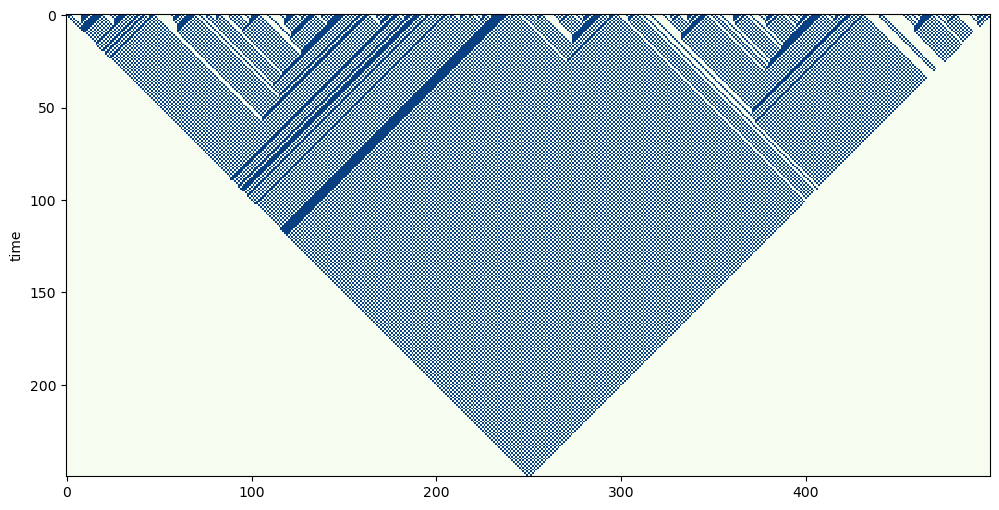

In [55]:
ca_184 = CA()
p = 0.5
L = 500
T = int(L / 2)
n=100
n_repetitions = 100
n_alpha = 2
p_values = [0.2,0.3,0.4,0.5,0.6,0.7] # Adjust as needed (np.linspace(0.1, 0.7, 7), to get same results as paper)
initial_state = ca_184.gen_initial_state_bernoulli(L, p)
v_max=5
p_slowdown=0.1

# print(cellular_automaton)
cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='GnBu')

# Plot the random walk that is the initial state, go up for 1, down for 0
random_walk = initial_to_random_walk(initial_state)
lifespan_counter, jam_size_counter = run_model(p, L, T, n)


In [ ]:

def run_model_over_density(p_values, L, T, n_repetitions=100):
    """
    Function to run the model for different density values.

    Parameters:
    - p_values (list): List of float values representing different densities.
    - L (int): The length of the CA.
    - T (int): The number of timesteps.
    - n_repetitions (int): The number of times the model should be run for each density.

    Returns:
    - lifespan_counters (list): List of Counters with lifespans for each density.
    - jam_counters (list): List of Counters with jam sizes for each density.
    - Results: list with density and related jam_counters
    """
    lifespan_counters = []
    jam_counters_list = []  #Changed to a list

    for p in p_values: #loop over different densities (p)
        total_lifespans = []
        total_jam_sizes = []

        for i in range(n_repetitions):
            ca_184 = CA()
            initial_state = ca_184.gen_initial_state_bernoulli(L, p)
            random_walk = initial_to_random_walk(initial_state)
            cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
            cellular_automaton = triangulize_evolution(cellular_automaton)

            lifespans = jam_lifespans(random_walk)
            total_lifespans += lifespans
            
            jams = find_elem_jams(cellular_automaton)
            jam_sizes = [jam[1] for jam in jams]
            total_jam_sizes += jam_sizes
        
        lifespan_counters.append(Counter(total_lifespans))
        jam_counters_list.append(Counter(total_jam_sizes))

    #Connect jam counts with density values for fit_power_law function
    results = [(p, jam_counters) for p, jam_counters in zip(p_values, jam_counters_list)]

    return lifespan_counters, results



def fit_power_law(results):
    """ Function to fit a power-law function to fit the different densities (p) and """
    fitted_parameters = []

    for p, jam_counters in results:
        lists = sorted(jam_counters.items())
        x, y = zip(*lists)

        # Fit power-law function
        def func(x, a, b):
            return a * x ** -b

        popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=[1, 0.1])
        a_optimal, b_optimal = popt

        fitted_parameters.append((p, b_optimal))

    return fitted_parameters

# Example usage
n_alpha = 100  # Define the number of iterations
all_densities = []
all_critical_exponents = []

for _ in range(n_alpha):
    # Assuming you have already run_model_over_density and obtained results
    lifespan_counters, results_x = run_model_over_density(p_values, L, T, n_repetitions)

    # Fit power-law and get fitted parameters
    fitted_parameters = fit_power_law(results_x)

    # Extract density and critical exponent values
    densities, critical_exponents = zip(*fitted_parameters)

    # Accumulate the results
    all_densities.append(densities)
    all_critical_exponents.append(critical_exponents)

# Plot the results
plt.figure(figsize=(8, 6))
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


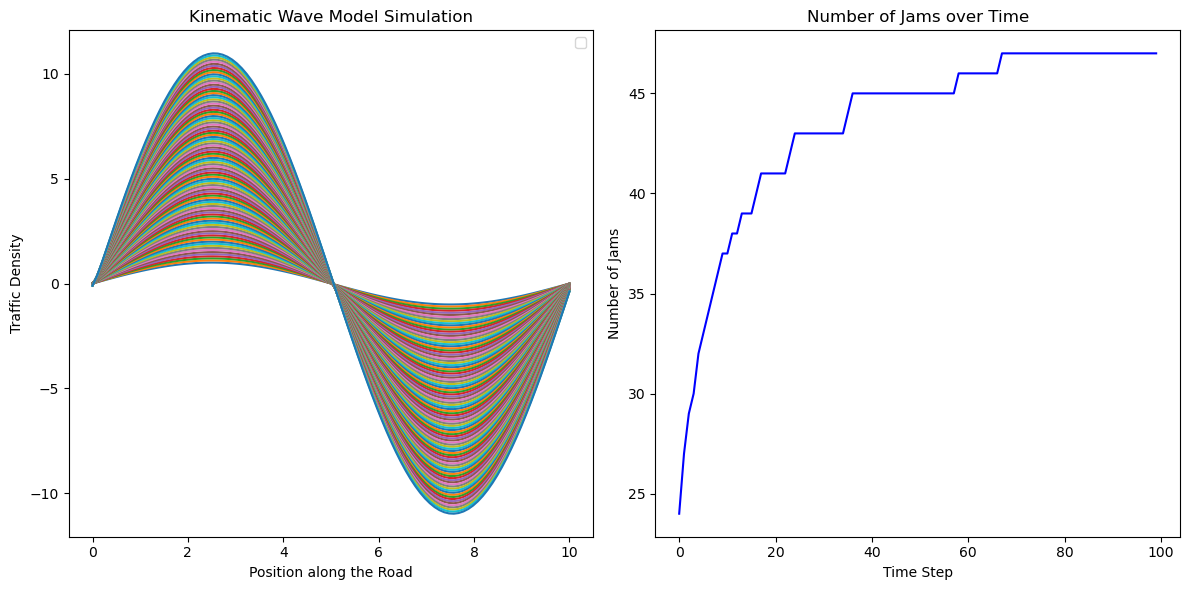

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def kinematic_wave_model(initial_density, road_length, time_steps, dt, vmax, density_function, jam_threshold):
    """
    Kinematic Wave model for traffic flow simulation.

    Parameters:
    - initial_density: Initial density profile along the road.
    - road_length: Length of the road.
    - time_steps: Number of time steps.
    - dt: Time step size.
    - vmax: Maximum speed of vehicles.
    - density_function: Function representing the initial density profile.
    - jam_threshold: Threshold density for identifying traffic jams.

    Returns:
    - density_history: List of density profiles at each time step.
    - num_jams: List of the number of jams at each time step.
    """

    density_history = [initial_density.copy()]
    num_jams = []

    for _ in range(time_steps):
        current_density = density_history[-1]

        # Calculate flow and speed
        flow = current_density * vmax
        speed = vmax * (1 - current_density)

        # Update density using the conservation equation
        density_change = (flow[:-1] - flow[1:]) * dt / road_length
        current_density[1:] += density_change
        current_density[0] += (flow[-1] - flow[0]) * dt / road_length

        # Apply the density function for dynamic variations
        current_density = density_function(current_density)

        density_history.append(current_density.copy())

        # Identify the number of jams
        num_jam = np.sum(current_density > jam_threshold)
        num_jams.append(num_jam)

    return density_history, num_jams

def plot_traffic_simulation(density_history, road_length, vmax, num_jams=None):
    """
    Plot the traffic simulation results.

    Parameters:
    - density_history: List of density profiles at each time step.
    - road_length: Length of the road.
    - vmax: Maximum speed of vehicles.
    - num_jams: List of the number of jams at each time step.
    """

    time_steps = len(density_history) - 1
    positions = np.linspace(0, road_length, len(density_history[0]))

    plt.figure(figsize=(12, 6))

    for t in range(time_steps + 1):
        plt.subplot(1, 2, 1)
        plt.plot(positions, density_history[t])

    plt.subplot(1, 2, 1)
    plt.title('Kinematic Wave Model Simulation')
    plt.xlabel('Position along the Road')
    plt.ylabel('Traffic Density')
    plt.legend()

    if num_jams is not None:
        plt.subplot(1, 2, 2)
        plt.plot(range(time_steps), num_jams, color='blue')
        plt.title('Number of Jams over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Jams')

    plt.tight_layout()
    plt.show()

# Example Usage:
initial_density = np.sin(np.linspace(0, 2 * np.pi, 100))
road_length = 10.0
time_steps = 100
dt = 0.1
vmax = 1.0
jam_threshold = 0.8

def density_function(density):
    # Example of a density function that adds a sinusoidal perturbation
    perturbation = 0.1 * np.sin(np.linspace(0, 2 * np.pi, len(density)))
    return density + perturbation

density_history, num_jams = kinematic_wave_model(initial_density, road_length, time_steps, dt, vmax, density_function, jam_threshold)
plot_traffic_simulation(density_history, road_length, vmax, num_jams)



In [65]:
#changed run model function introducing stochasticity/dynamics Influx=Outflux 
def run_model_stochastic(p, L, T, n_repetitions=100, v_max=5, p_slowdown=0.1):
    """
    Function to run the model for a given p, L, T. It returns the lifespans and jam sizes of all the jams found in the evolution of the CA.

    Parameters:
    - p (float): The probability of a cell being 1 in the initial state.
    - L (int): The length of the CA.
    - T (int): The number of timesteps.
    - n_repetitions (int): The number of times the model should be run.
    - v_max (int): Maximum speed of vehicles.
    - p_slowdown (float): Probability of slowing down.

    Returns:
    - lifespan_counter (Counter): A counter with the lifespans of all the jams found in the evolutions of the CA.
    - jam_counter (Counter): A counter with the sizes of all the jams found in the evolutions of the CA.
    """
    ca_184 = CA()
    total_lifespans = []
    total_jam_sizes = []

    for i in range(n_repetitions):
        initial_state = ca_184.gen_initial_state_bernoulli(L, p)
        random_walk = initial_to_random_walk(initial_state)

        for t in range(T):
            #Acceleration: Increase the speed of each vehicle by 1, up to the maximum speed
            random_walk = [min(v + 1, v_max) for v in random_walk]

            #Randomization: With probability p_slowdown, reduce the speed of each vehicle by 1
            random_walk = [v - 1 if random.random() < p_slowdown and v > 0 else v for v in random_walk]

            #Movement: Move each vehicle forward by its speed
            random_walk = [0 if (v + 1) == 0 or random.random() < 1 / (v + 1) else v for v in random_walk]


        cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
        cellular_automaton = triangulize_evolution(cellular_automaton)

        lifespans = jam_lifespans(random_walk)
        total_lifespans += lifespans

        jams = find_elem_jams(cellular_automaton)
        jam_sizes = [jam[1] for jam in jams]
        total_jam_sizes += jam_sizes

    lifespan_counter = Counter(total_lifespans)
    jam_counter = Counter(total_jam_sizes)
    return lifespan_counter, jam_counter


In [ ]:
#fit power law curve: density as a function of the critical exponents
# Calculate mean and standard deviation of critical exponents
mean_critical_exponents = np.mean(all_critical_exponents, axis=0)
std_critical_exponents = np.std(all_critical_exponents, axis=0)

# Fit a curve to the mean critical exponents
def func(x, a, b):
    return a * x ** -b 

popt, pcov = curve_fit(func, all_densities[0], mean_critical_exponents, p0=[1, 0.5])

# Plot the results
plt.figure(figsize=(8, 6))

#Plot individual datapoints from iterations
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o', color="blue")

#Plot the mean values with std dev
plt.errorbar(all_densities[0], mean_critical_exponents, yerr=std_critical_exponents, fmt='o-', color='black', label='Mean ± StdDev')

#plot the fitted curve
x_fit = np.linspace(min(all_densities[0]), max(all_densities[0]), 100)
y_fit = func(x_fit, *popt)
plt.plot(x_fit, y_fit, '--', color='red', label=f'Fitted Curve: a={popt[0]:.2f}, b={popt[1]:.2f}')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density for L=500')
plt.legend()
plt.show()

In [ ]:
#fit linear curve: density as a function of the critical exponents
# Calculate mean and standard deviation of critical exponents
mean_critical_exponents = np.mean(all_critical_exponents, axis=0)
std_critical_exponents = np.std(all_critical_exponents, axis=0)

# Fit a linear curve to the mean critical exponents
def linear_func(x, a, b):
    return a * x + b

popt_linear, pcov_linear = curve_fit(linear_func, all_densities[0], mean_critical_exponents, p0=[1, 0.5])

# Plot the results
plt.figure(figsize=(8, 6))

# Plot individual datapoints from iterations
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o', color="blue")

# Plot the mean values with std dev
plt.errorbar(all_densities[0], mean_critical_exponents, yerr=std_critical_exponents, fmt='o-', color='black', label='Mean ± StdDev')

# Plot the fitted linear curve
x_fit = np.linspace(min(all_densities[0]), max(all_densities[0]), 100)
y_fit_linear = linear_func(x_fit, *popt_linear)
plt.plot(x_fit, y_fit_linear, '--', color='red', label=f'Fitted Linear Curve: a={popt_linear[0]:.2f}, b={popt_linear[1]:.2f}')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density for L=500')
plt.legend()
plt.show()

In [24]:
#set up function to fit power law distribution
def analyze_powerlaw_distribution(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    (Only designed for heavy tailed distributions!)
    Makes use of the Kolmogorov-Smirnov test for which H0: data is power-law distributed, HA: data is not power-law distributed
    If H0 is rejected, the function will check if the data is exponentially distributed 
    If the function is not exponentially distributed, the function will return:
      "Not a power-law distribution (No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    ks_stat, ks_p_value = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

    # Analyze the fit and return the result
    if ks_p_value < 0.05:
        # Reject the null hypothesis (data is unlikely to be power-law distributed)
        result = "Not a power-law distribution"

        # Check for alternative distribution (exponential)
        if fit.power_law.alpha is not None:
            result += f" (Exponential fit p-value: {ks_p_value:.4f})"
        else:
            result += " (No alternative distribution fit available)"
    else:
        # Accept the null hypothesis (data is likely to be power-law distributed)
        result = "Power-law distribution"

    return result



Calculating best minimal value for power law fit
Power-law distribution


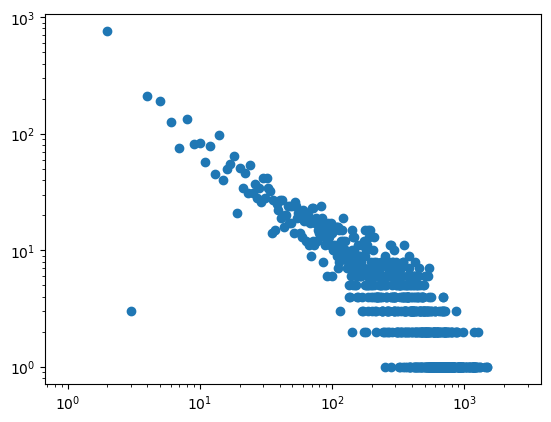

In [66]:
lifespan_count, jam_count = run_model_stochastic(p, L, T, n_repetitions, v_max, p_slowdown)

result_jam_test = analyze_powerlaw_distribution(list(jam_count.elements()))
print(result_jam_test)


#plt.hist(list(jam_size_counter.elements()), bins=100, density=True, label="Jam size distribution")
plt.loglog(range(1, int(max(jam_count.keys()))), [jam_count[i] for i in range(1, int(max(jam_count.keys())))], 'o')

In [47]:
#set up function to fit power law distribution and other distributions
def analyze_powerlaw_distribution2(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    
    Makes use of the Kolmogorov-Smirnov test for which H0: data is .. distributed, HA: data is not .. distributed
    If H0 is rejected for the power law distribution, the function will check if the data is exponentially,bionomial,gamma or poisson distributed 
    If the function is not matched with any of these distributions, the function will return:
      "No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True, verbose=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    ks_stat_powerlaw, ks_p_value_powerlaw = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

#Check for power law distribution
    if ks_p_value_powerlaw < 0.05:
        result = "Not a power-law distribution"

        #Calculate p-values for alternative distributions
        ks_p_value_exponential = ks_2samp(data, np.random.exponential(np.mean(data), len(data)))[1]
        ks_p_value_poisson = ks_2samp(data, poisson.rvs(np.mean(data), size=len(data)))[1]
        ks_p_value_binomial = ks_2samp(data, np.random.binomial(n=int(np.mean(data)), p=0.5, size=len(data)))[1]
        ks_p_value_gamma = ks_2samp(data, gamma.rvs(np.mean(data)/2, scale=2, size=len(data)))[1]

        #Check alternative distributions, because we did 4 tests, we need to correct for multiple testing with bonferroni (0.05/4)
        if ks_p_value_exponential < 0.05/4:
            result += f" (Exponential fit p-value: {ks_p_value_exponential:.4f})"
        elif ks_p_value_poisson < 0.05/4:
            result += " (Poisson distribution)"
        elif ks_p_value_binomial < 0.05/4:
            result += " (Binomial distribution)"
        elif ks_p_value_gamma < 0.05/4:
            result += " (Gamma distribution)"
        else:
            result += " (No alternative distribution fit available)"

    else:
        result = "Power-law distribution"


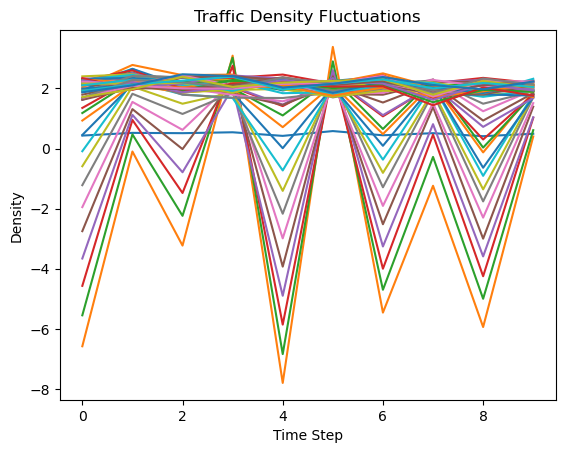

In [84]:
#addition of avalanche size and density history 

def run_model_stochastic_dens_avalanche(p, L, T, n_repetitions=100, v_max=5, p_slowdown=0.1):
    """
    Function to run the model for a given p, L, T. It returns the lifespans, jam sizes, and avalanche sizes of all the jams found in the evolution of the CA.

    Parameters:
    - p (float): The probability of a cell being 1 in the initial state.
    - L (int): The length of the CA.
    - T (int): The number of timesteps.
    - n_repetitions (int): The number of times the model should be run.
    - v_max (int): Maximum speed of vehicles.
    - p_slowdown (float): Probability of slowing down.

    Returns:
    - density_history (list): List of density profiles at each time step.
    - lifespan_counter (Counter): A counter with the lifespans of all the jams found in the evolutions of the CA.
    - jam_counter (Counter): A counter with the sizes of all the jams found in the evolutions of the CA.
    - avalanche_sizes (list): List of avalanche sizes.
    """
    ca_184 = CA()
    total_lifespans = []
    total_jam_sizes = []
    density_history = []
    avalanche_sizes = []

    for i in range(n_repetitions):
        initial_state = ca_184.gen_initial_state_bernoulli(L, p)
        random_walk = initial_to_random_walk(initial_state)
        density_profile = [np.sum(initial_state) / L]  # Initial density profile
        avalanche_size = 0

        for t in range(T):
            # Acceleration: Increase the speed of each vehicle by 1, up to the maximum speed
            random_walk = [min(v + 1, v_max) for v in random_walk]

            # Randomization: With probability p_slowdown, reduce the speed of each vehicle by 1
            random_walk = [v - 1 if random.random() < p_slowdown and v > 0 else v for v in random_walk]

            # Movement: Move each vehicle forward by its speed
            random_walk = [0 if (v + 1) == 0 or random.random() < 1 / (v + 1) else v for v in random_walk]

            # Update density profile
            density_profile.append(np.sum(random_walk) / L)

            # Check for the end of an avalanche
            if random_walk[-1] == 0:
                avalanche_sizes.append(avalanche_size)
                avalanche_size = 0
            else:
                avalanche_size += 1

        density_history.append(density_profile)

        cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
        cellular_automaton = triangulize_evolution(cellular_automaton)

        lifespans = jam_lifespans(random_walk)
        total_lifespans += lifespans

        jams = find_elem_jams(cellular_automaton)
        jam_sizes = [jam[1] for jam in jams]
        total_jam_sizes += jam_sizes

    lifespan_counter = Counter(total_lifespans)
    jam_counter = Counter(total_jam_sizes)
    return density_history, lifespan_counter, jam_counter, avalanche_sizes

# Example usage
p = 0.5
L = 100
T = int(L / 2)
n_repetitions = 10

density_history, lifespan_counter, jam_counter, avalanche_sizes = run_model_stochastic(p, L, T, n_repetitions)

# Assuming density_history is a list of density arrays over time
time_steps = len(density_history)
time = range(time_steps)

plt.plot(time, density_history, label='Density')
plt.xlabel('Time Step')
plt.ylabel('Density')
plt.title('Traffic Density Fluctuations')
#plt.legend()
plt.show()




In [ ]:
# Example usage
p = 0.5
L = 100
T = int(L / 2)
n_repetitions = 10

density_history, lifespan_counter, jam_counter, avalanche_sizes = run_model_stochastic(p, L, T, n_repetitions)

# Assuming density_history is a list of density arrays over time
time_steps = len(density_history)
time = range(time_steps)

plt.plot(time, density_history, label='Density')
plt.xlabel('Time Step')
plt.ylabel('Density')
plt.title('Traffic Density Fluctuations')
#plt.legend()
plt.show()

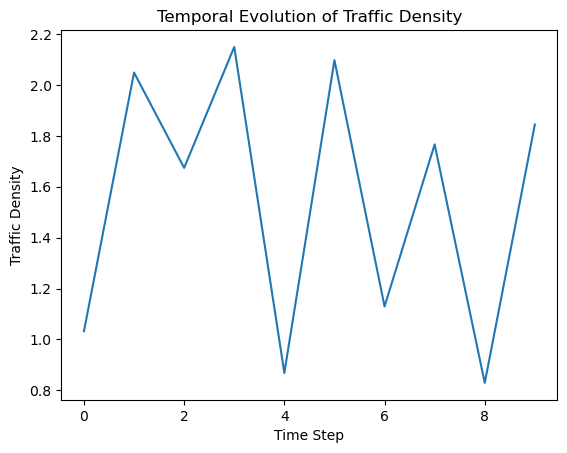

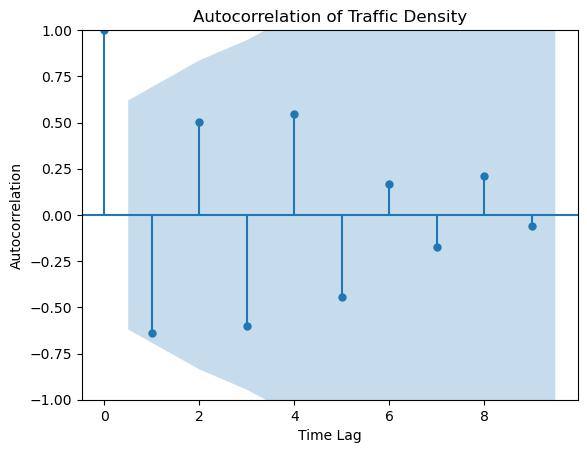

In [86]:


#input= density_history (list of density arrays over time)
time_series = np.mean(density_history, axis=1)
#see if we can observe avalanche like behavior: one small perturbation can cause a large disturbance as traffic conditions in 
#time step x influence the next time step.
plt.plot(time_series)
plt.xlabel('Time Step')
plt.ylabel('Traffic Density')
plt.title('Temporal Evolution of Traffic Density')
plt.show()

#Autocorrelation function acf, 
#"Critical" traffic models show disturbances propagating across the road. 
#High cross-correlation values at certain time lags and positions indicate synchronized behavior
plot_acf(time_series)
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Traffic Density')
plt.show()



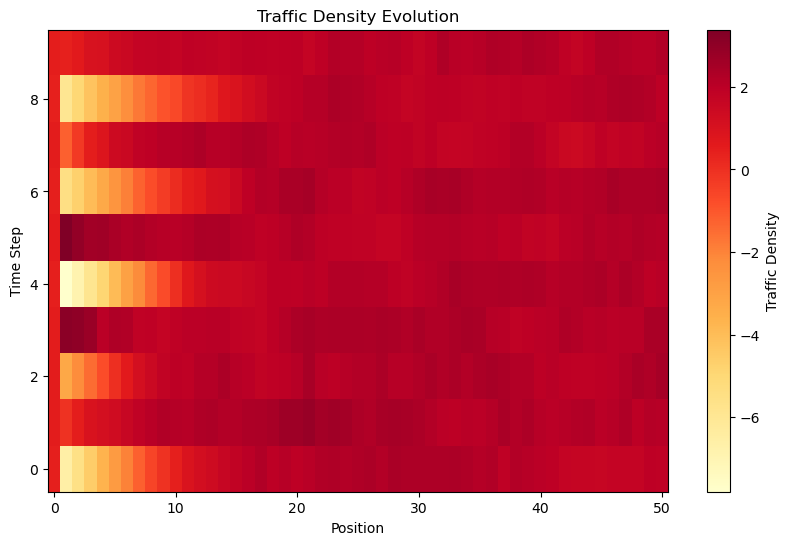

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def plot_traffic_density(evolution):
    """
    Plot the traffic density heatmap.

    Parameters:
    - evolution (numpy.ndarray): Traffic density evolution over time and space.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(evolution, cmap='YlOrRd', aspect='auto', origin='lower')
    plt.colorbar(label='Traffic Density')
    plt.xlabel('Position')
    plt.ylabel('Time Step')
    plt.title('Traffic Density Evolution')

    plt.show()

#Plot traffic density for each timestep at different positions to show pattern which shows SOC -> 
plot_traffic_density(density_history)
